In [1]:
import matplotlib.pyplot as plt
import numpy as np


import scipy.linalg as la

from qiskit import execute
from qiskit import Aer
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel

from racbem import *

import os
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/Users/flynn_chen/.pyxbld/temp.macosx-10.9-x86_64-3.7/pyrex/qutip/cy/openmp/parfuncs.cpp:636:10: fatal error: 'src/zspmv_openmp.hpp' file not found
#include "src/zspmv_openmp.hpp"
         ^~~~~~~~~~~~~~~~~~~~~~
1 error generated.


In [2]:
def GetBackend(backend_name=None):
    if backend_name == None:
        backend = Aer.get_backend('unitary_simulator')
        #backend = Aer.get_backend('qasm_simulator')
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
    return backend

To get consistent output:
1. remove random noise (sigma=0)
2. set seed = 0, and added seed in the build_random_circuit

In [3]:
backend_name = 'ibmq_burlington'
#backend_name = None
kappa = 5                   # condition number
n_sys_qubit = 3             # the number of system qubits
n_be_qubit = 1              # the number of block-encoding qubit
n_sig_qubit = 1             # the number of signal qubit
n_tot_qubit = n_sig_qubit+n_be_qubit+n_sys_qubit
n_depth = 15                # the depth of random circuit
prob_one_q_op = 0.5         # the probability of selecting a one-qubit
                            # operation when two_q_op is allowed
basis_gates = ['u1','u2','cx']
digit_shots = 13
n_shots = 2**digit_shots    # the number of shots used in measurements
sigma = 0                # parameter used to rescale noise model
# state |0^n>
b = np.zeros((2**n_sys_qubit,))
b[0] = 1.0
load_architecture = True    # True:     load architure locally
                            # False:    need to save an IBM account beforehand

In [4]:
# seed = 0
# np.random.seed(seed)

# phi_types = np.zeros((5, 7))

# #zero rotation
# phi_types[0, :] = np.zeros(7)

# #sample from uniformly random
# phi_types[1, :] = np.random.rand(7) * np.pi

# #sample from gaussian random
# phi_types[2, :] = np.random.normal(size=7) % np.pi

# #sample from binomial random
# phi_types[3, :] = np.random.binomial(10, 0.5, size=7) % np.pi

# #sample from exponential random
# phi_types[4, :] = np.random.exponential(size=7) % np.pi

# print(phi_types)

seed = 0
num_trials = 100
np.random.seed(seed)
#phi_types = np.random.rand(num_trials,7) * np.pi
phi_types = np.random.normal(size=(num_trials,7)) % np.pi
print(phi_types)

[[1.76405235 0.40015721 0.97873798 2.2408932  1.86755799 2.16431477
  0.95008842]
 [2.99023545 3.0383738  0.4105985  0.14404357 1.45427351 0.76103773
  0.12167502]
 [0.44386323 0.33367433 1.49407907 2.93643439 0.3130677  2.28749691
  0.58860284]
 [0.6536186  0.8644362  2.39942763 2.26975462 1.68722698 0.04575852
  2.9544088 ]
 [1.53277921 1.46935877 0.15494743 0.37816252 2.25380691 1.16079619
  2.7936805 ]
 [0.15634897 1.23029068 1.20237985 2.75426584 2.8392899  2.09303969
  1.72157472]
 [1.43532246 1.9507754  2.63194047 2.70351835 1.88879729 0.77749036
  1.52769481]
 [2.92885237 2.24612609 0.3869025  2.63078752 1.96096047 3.11341043
  0.42833187]
 [0.06651722 0.3024719  2.50727056 2.77885149 2.46913221 2.78203949
  2.32844637]
 [1.41531005 0.17742614 2.73981172 1.51139431 0.46278226 2.23429429
  0.0519454 ]
 [0.72909056 0.12898291 1.13940068 1.90676683 0.40234164 2.45678256
  2.2707955 ]
 [2.56274299 2.83004012 0.05616534 1.97644281 0.90082649 0.46566244
  1.60534897]
 [1.48825219 1.8

In [5]:
poly_fit_val_list = []

for i in range(phi_types.shape[0]):
    seed = 0
    np.random.seed(seed)

    # instances of RACBEM
    be = BlockEncoding(n_be_qubit, n_sys_qubit)
    qsp = QSPCircuit(n_sig_qubit, n_be_qubit, n_sys_qubit)

    # retrieve backends and architectures
    backend = GetBackend()
    if load_architecture:
        if os.path.exists(backend_name+'_backend_config.pkl'):
            noise_backend = pickle.load(open(backend_name+'_backend_config.pkl','rb'))
            noise_model = NoiseModel.from_dict(noise_backend['noise_dict'])
            coupling_map = noise_backend['coupling_map']
            tot_q_device = noise_backend['tot_q_device']
            print("\nload architecture locally at: %s_backend_config.pkl\n"%(backend_name))
        else:
            raise Exception("no locally saved architecture: %s_backend_config.pkl"%(backend_name), load_architecture)
    else:
        noise_backend = GetBackend(backend_name=backend_name)
        coupling_map = noise_backend.configuration().coupling_map
        noise_model = NoiseModel.from_backend(noise_backend)
        tot_q_device = noise_backend.configuration().n_qubits
        pickle.dump({'noise_dict': noise_model.to_dict(), 'coupling_map': coupling_map, 'tot_q_device': tot_q_device, 
                    'basis_gates': noise_backend.configuration().basis_gates}, open(backend_name+'_backend_config.pkl','wb'))
        print("retrieve architecture from IBM Q and save locally at: %s_backend_config.pkl\n"%(backend_name))
    assert tot_q_device >= n_tot_qubit
    new_noise_model = scale_noise_model(noise_model, sigma)

    # exclude qubit 0 as signal qubit, shift the remaining labels by -1
    be_map = [[q[0]-1,q[1]-1] for q in coupling_map if (0 not in q) and 
            (q[0] < n_tot_qubit) and (q[1] < n_tot_qubit)]
    be.build_random_circuit(n_depth, basis_gates=basis_gates, 
            prob_one_q_op=prob_one_q_op, coupling_map=be_map, seed=seed)
    be.build_dag()

    # load phase factors
    data = np.loadtxt("phi_inv_%d.txt"%(kappa))
    #phi_seq = data[:-2]
    phi_seq = phi_types[i, :]
    scale_fac = data[-2]
    app_err = data[-1]

    # retrieve block-encoded matrix
    UA = retrieve_unitary_matrix(be.qc)
    A = UA[0:2**n_sys_qubit, 0:2**n_sys_qubit]
    (svd_U, svd_S, svd_VH) = la.svd(A)

    # succ prob via measurement
    qsp.build_circuit(be.qc, be.qc_dag, phi_seq, realpart=True, measure=False)
    compiled_circ = qsp.qcircuit
    job = execute(compiled_circ, backend=backend, shots=n_shots, seed_transpiler=seed, seed_simulator=seed)
    job_monitor(job)
    result = job.result()
    
    transformed_U = result.get_unitary(compiled_circ, decimals=3)
    transformed_A = transformed_U[0:2**n_sys_qubit, 0:2**n_sys_qubit]
    (transformed_svd_U, transformed_svd_S, transformed_svd_VH) = la.svd(transformed_A)
    
    print("singular value (A) = \n", np.around(svd_S, decimals=3))
    print("transformed singular value (A) = \n", np.around(transformed_svd_S, decimals=3))
    #print(A)
    #print(transformed_A)
    
    poly_fit_val = np.polynomial.chebyshev.Chebyshev.fit(svd_S, transformed_svd_S, 2, full=True)
    poly_fit_val_list.append(poly_fit_val)
    


load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.974 0.974 0.972 0.971 0.902 0.898 0.882 0.882]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.807 0.804 0.802 0.799 0.792 0.787 0.779 0.774]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.651 0.648 0.618 0.601 0.539 0.52  0.518 0.487]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.753 0.751 0.737 0.729 0.675 0.674 0.666 0.663]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.978 0.976 0.976 0.975 0.975 0.975 0.974 0.973]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.915 0.914 0.908 0.901 0.825 0.815 0.814 0.81 ]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.867 0.864 0.856 0.855 0.847 0.846 0.842 0.841]

load architecture 

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.578 0.577 0.577 0.575 0.486 0.486 0.442 0.442]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.69  0.681 0.676 0.656 0.615 0.613 0.607 0.595]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.904 0.903 0.902 0.9   0.858 0.857 0.847 0.845]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.768 0.766 0.74  0.736 0.628 0.627 0.616 0.613]

load architecture 

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.872 0.871 0.868 0.865 0.806 0.805 0.793 0.79 ]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.808 0.806 0.801 0.79  0.743 0.735 0.734 0.734]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.834 0.833 0.827 0.827 0.805 0.803 0.799 0.797]

load architecture locally at: ibmq_burlington_backend_config.pkl

Job Status: job has successfully run
singular value (A) = 
 [0.893 0.893 0.795 0.795 0.49  0.49  0.477 0.477]
transformed singular value (A) = 
 [0.554 0.553 0.52  0.515 0.409 0.409 0.384 0.38 ]

load architecture 

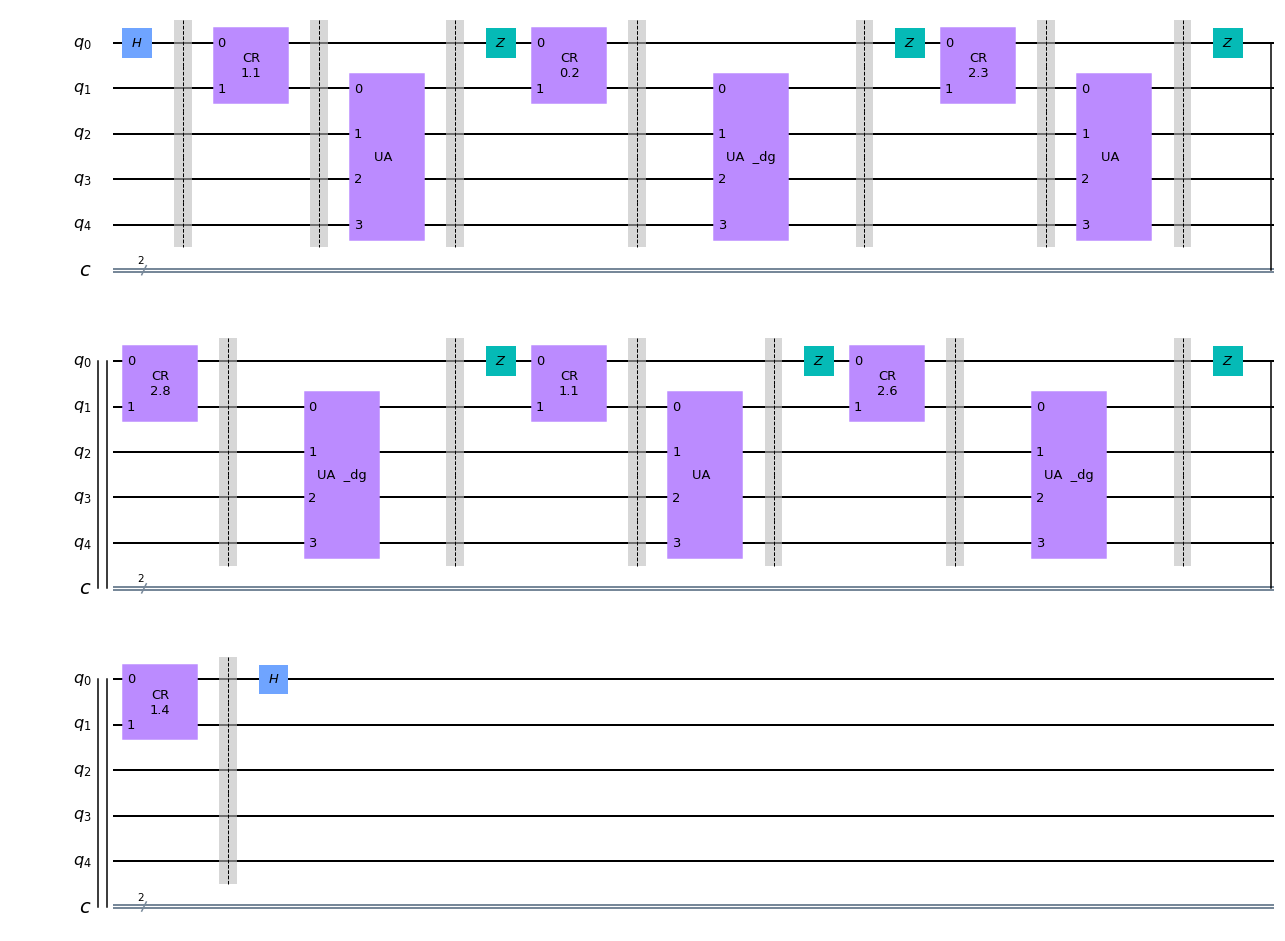

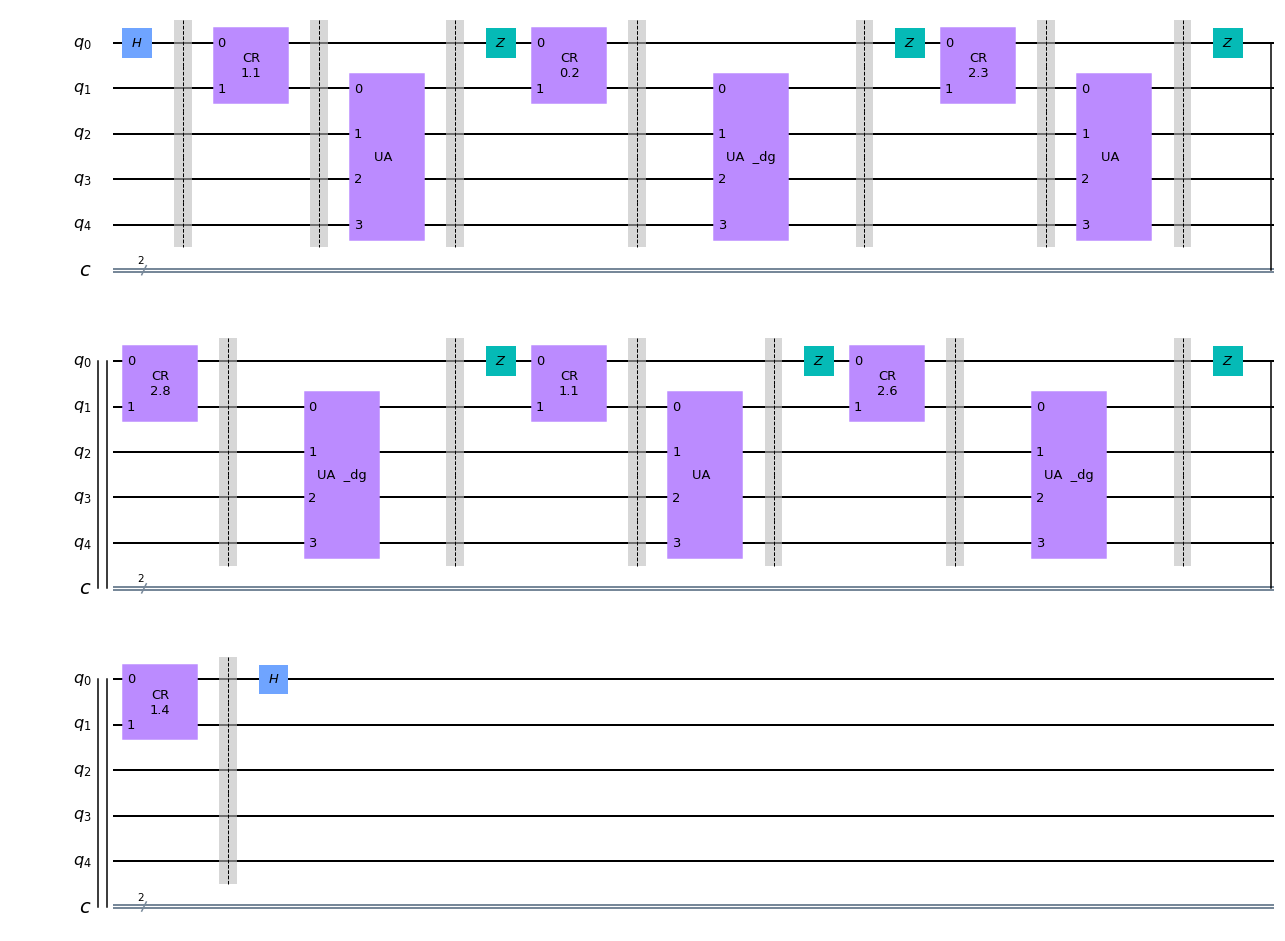

In [6]:
qsp.qcircuit.draw(output='mpl')

In [7]:
coeff = np.zeros((num_trials, 3))
for i, poly_fit_val in enumerate(poly_fit_val_list):
    coeff[i, :] = poly_fit_val[0].convert().coef

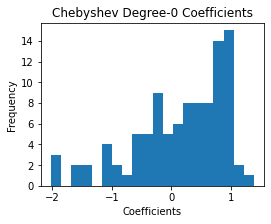

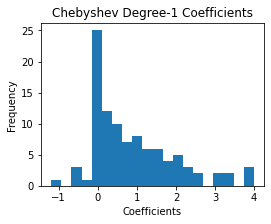

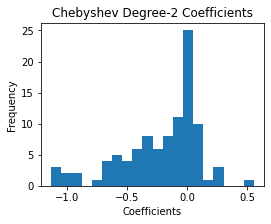

In [8]:
plt.figure(figsize=(4,3))
plt.hist(coeff[:, 0], bins=20)  # density=False would make counts
plt.title('Chebyshev Degree-0 Coefficients')
plt.ylabel('Frequency')
plt.xlabel('Coefficients')
plt.show()

plt.figure(figsize=(4,3))
plt.hist(coeff[:, 1], bins=20)  # density=False would make counts
plt.title('Chebyshev Degree-1 Coefficients')
plt.ylabel('Frequency')
plt.xlabel('Coefficients')
plt.show()

plt.figure(figsize=(4,3))
plt.hist(coeff[:, 2], bins=20)  # density=False would make counts
plt.title('Chebyshev Degree-2 Coefficients')
plt.ylabel('Frequency')
plt.xlabel('Coefficients')
plt.show()